In [68]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sn
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, GlobalMaxPooling1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib




In [87]:
#Reading data sourced from Reddit News
df1=pd.read_csv("upload_DJIA_table.csv")
df2=pd.read_csv("Combined_News_DJIA.csv")

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

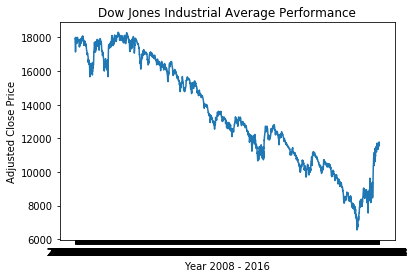

In [28]:
#Plot DJIAP 
plt.plot( 'Date', 'Adj Close', data=df1)
plt.title('Dow Jones Industrial Average Performance')
plt.xlabel('Year 2008 - 2016')
plt.ylabel('Adjusted Close Price')

plt.show()

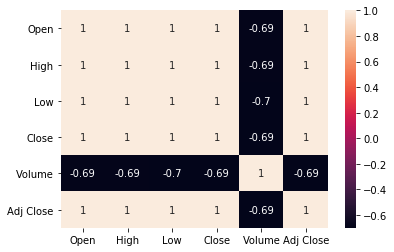

In [29]:
correlation = df1.corr()
sn.heatmap(correlation, annot=True)
plt.show()

In [30]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df2, nGraphShown, nGraphPerRow):
    nunique = df2.nunique()
    df2 = df2[[col for col in df2 if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df2.shape
    columnNames = list(df2)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df2.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('News')
        plt.xlabel('Sentiment "positive "1", negative "0" ')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

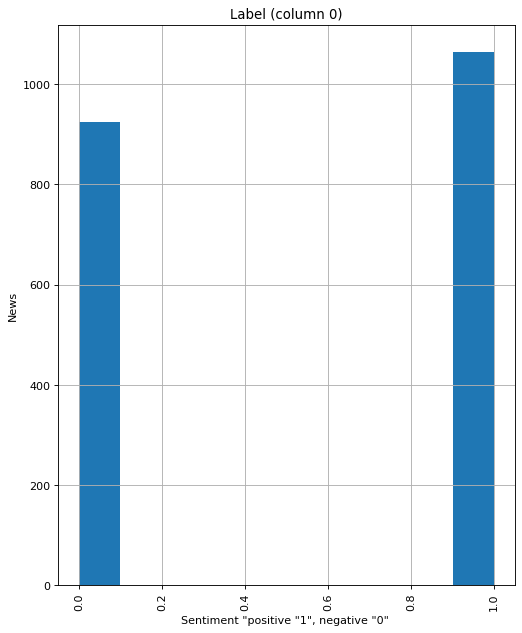

In [31]:
plotPerColumnDistribution(df2, 10, 5)

In [69]:
#Pre-processing the data using NLP techniques
#Cleaning the data of punctuations and capital letters
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)




In [70]:
#Combining all columns of preprocessed news data in one
News_col = []
for row in range(0,len(df2)):
    News_col.append(' '.join(str(x) for x in df2.iloc[row,2:]))

    
RedditNews = []
sentences = list(News_col)
for sen in sentences:
    RedditNews.append(preprocess_text(sen))
    
RedditNews [1]

'b Why wont America and Nato help us If they wont help us now why did we help them in Iraq Bush puts foot down on Georgian conflict Jewish Georgian minister Thanks to Israeli training we re fending off Russia Georgian army flees in disarray as Russians advance Gori abandoned to Russia without shot fired Olympic opening ceremony fireworks faked What were the Mossad with fraudulent New Zealand Passports doing in Iraq Russia angered by Israeli military sale to Georgia An American citizen living in Ossetia blames S and Georgian leaders for the genocide of innocent people Welcome To World War IV Now In High Definition Georgia move mistake of monumental proportions Russia presses deeper into Georgia S says regime change is goal Abhinav Bindra wins first ever Individual Olympic Gold Medal for India U ship heads for Arctic to define territory Drivers in Jerusalem taxi station threaten to quit rather than work for their new boss an Arab The French Team is Stunned by Phelps and the m Relay Team 

In [71]:
#Inputting the categorical data where 1 is postive and 0 is negative
Sentiment = df2['Label']
Sentiment = np.array(list(map(lambda x: 1 if x==1 else 0, Sentiment)))

In [72]:
#Training the data using an 80:20 split
RedditNews_train, RedditNews_test, Sentiment_train, Sentiment_test = train_test_split(RedditNews, Sentiment, test_size=0.20, random_state=42)

In [73]:
#Tokenized sentences into 'words'
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(RedditNews_train)

RedditNews_train = tokenizer.texts_to_sequences(RedditNews_train)
RedditNews_test = tokenizer.texts_to_sequences(RedditNews_test)

In [74]:
#Setting the length of vocabulary
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

RedditNews_train = pad_sequences(RedditNews_train, padding='post', maxlen=maxlen)
RedditNews_test = pad_sequences(RedditNews_test, padding='post', maxlen=maxlen)
vocab_size

30248

In [75]:
#Creating the embedding layer using external dictionary from stanford
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [76]:
#Creating and embedding matrix
#End of preprocessing
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [90]:
#Applying a Linear Regression network to train
#from sklearn.linear_model import LogisticRegression

#classifier = LogisticRegression()
#training = classifier.fit(RedditNews_train, Sentiment_train)
#pred = training.predict(RedditNews_test)

#score = classifier.score(Sentiment_test, pred)

#print("Training Accuracy:", score)


In [86]:
#Creating the Convolutional neural network to train
model = Sequential()
batch_size = 32
epochs = 2

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

#Creating a layer of 250 kernels of window size 5
model.add(Conv1D(250, 3, strides =4 ,activation='relu'))
model.add(Conv1D(128, 3, strides =3 ,activation='relu'))
model.add(Conv1D(128, 3, strides =2 ,activation='relu'))
model.add(Conv1D(64, 3, strides =1 ,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#Displaying the accurac
loss, accuracy = model.evaluate(RedditNews_train, Sentiment_train, verbose=False)
loss, accuracy = model.evaluate(RedditNews_test, Sentiment_test, verbose=False)

print("The accuracy of results from the CNN Training is {:.4f}".format(accuracy))

The accuracy of results from the CNN Training is 0.4422


In [12]:
#Displaying the model
print (model.output_shape)
print (model.summary())

(None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3024800   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 250)           75250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 128)            96128     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            49280     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)        

In [78]:
#Training and evaluating the model using Naive Bayesian
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm

RedditNews_train2, RedditNews_test2, Sentiment_train, Sentiment_test = train_test_split(RedditNews, Sentiment, test_size=0.20, random_state=42)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Sentiment_train)
Test_Y = Encoder.fit_transform(Sentiment_test)

#Defining the threshold for unique words
Tfidf_vect = TfidfVectorizer( max_features=5000)
Tfidf_vect.fit(RedditNews)
Train_X_Tfidf = Tfidf_vect.transform(RedditNews_train2)
Test_X_Tfidf = Tfidf_vect.transform(RedditNews_test2)

# Using Naive Bayesian to get accuracy
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("The accuracy of results from Naive Bayesian is ",accuracy_score(predictions_NB, Test_Y)*100)

The accuracy of results from Naive Bayesian is  53.266331658291456


In [79]:
#Training and Evaluating the model using SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

predictions_SVM = SVM.predict(Test_X_Tfidf)

print("The accuracy of results from SVM Training is ",accuracy_score(predictions_SVM, Test_Y)*100)

The accuracy of results from SVM Training is  49.74874371859296


In [84]:
#Training and Evaluating the model using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

cvec=CountVectorizer(ngram_range=(2,2),max_features=100009)
traindataset=cvec.fit_transform(RedditNews_train2)
RFC = RandomForestClassifier(n_estimators=200,criterion='entropy')
RFC.fit(traindataset,Sentiment_train)

test_dataset = cvec.transform(RedditNews_test2)
predictions = RFC.predict(test_dataset)

matrix=confusion_matrix(Sentiment_test,predictions)
score=accuracy_score(Sentiment_test,predictions)
print("The accuracy of results from RandomForestClassifier Training is ",score*100)

The accuracy of results from RandomForestClassifier Training is  52.76381909547738
